<a href="https://colab.research.google.com/github/StevenHsuYL/aicup_navi/blob/main/AICUP_navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **AI CUP 2024 競賽二（空拍圖生成線條）**

**TEAM_5447 程式碼**

## **Download training dataset**

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# 解壓縮檔案
!unzip -q '/content/drive/MyDrive/AICUP_2024/35_Competition 2_Training dataset_V3.zip'

## **Import Packages**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip
import torchvision.models as models
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install git+https://github.com/lartpang/PySODMetrics.git
import py_sod_metrics
import shutil

  Cloning https://github.com/lartpang/PySODMetrics.git to /tmp/pip-req-build-r_c0jvtk
  Running command git clone --filter=blob:none --quiet https://github.com/lartpang/PySODMetrics.git /tmp/pip-req-build-r_c0jvtk
  Resolved https://github.com/lartpang/PySODMetrics.git to commit 4b1091a474133a4dfd3b1220b63a6669c8b1e774
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysodmetrics: filename=pysodmetrics-1.4.2-py3-none-any.whl size=16108 sha256=25d29cc09efd14ba830b3504c472dbd84ed119c01fb865818a7912d110625da7
  Stored in directory: /tmp/pip-ephem-wheel-cache-llo2g5hb/wheels/05/9f/5b/1f408258fcd0b5808871e08e28be7e42641780675d753c1932
Successfully built pysodmetrics


## **Pre-processing**

(240, 428)


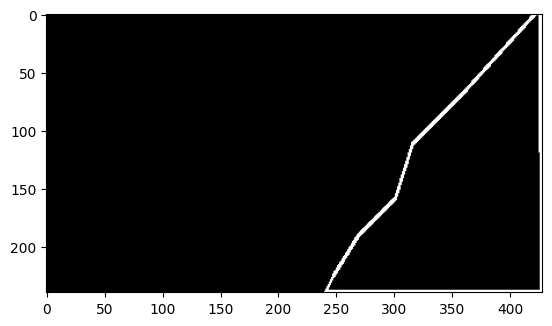

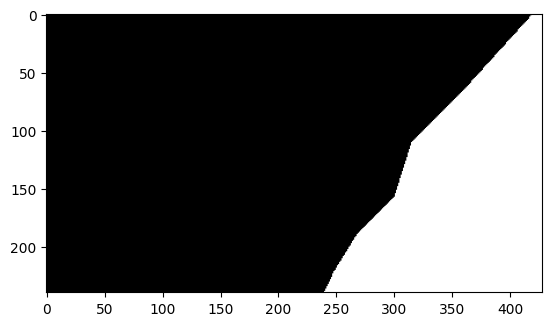

In [4]:
# Pre-processing of the label images: Fill the box with white color.

train_data = '/content/Training_dataset/'
GT_old_path = train_data + 'label_img'
GT_new_path = train_data + 'label_img_new'
os.makedirs(GT_new_path, exist_ok=True)

GT_old = sorted([os.path.join(GT_old_path, f) for f in os.listdir(GT_old_path)])
for gt_path in GT_old:
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    # Add a border to the mask
    mask_with_border = cv2.copyMakeBorder(gt, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

    # Define a seed point (middle row, inside the label box)
    row = 120
    line = False
    line_start, line_end = 0, 0
    box_start, box_end = 0, 0
    line_count = 0
    for j in range(gt.shape[1]):
        # Meet a line
        if gt[row, j] != 0 and j < gt.shape[1] - 1:
            if line == False:
                line = True
                line_start = j
                if line_count == 0: box_start = j
        else:  # gt[row, j] == 0 or j = gt.shape[1] - 1
            # At right side of a line or the right edge of the image
            if line == False: continue
            else: # line == True
                line = False
                line_end = j
                if line_end - line_start in range(1, 20):
                    line_count += 1
                    if line_count == 2:  # Outside the box.
                        box_end = j
                        seed_j = (box_start + box_end ) // 2
                        seed_point = (seed_j, row)
                        break

    # Fill the area inside the edges with white color
    filled_gt = gt.copy()
    cv2.floodFill(filled_gt, mask_with_border, seed_point, 255)

    # Save the filled mask to a file
    output_path = os.path.join(GT_new_path, os.path.split(gt_path)[-1])
    cv2.imwrite(output_path, filled_gt)

gt = cv2.imread('/content/Training_dataset/label_img/TRA_RI_2000001.png', cv2.IMREAD_UNCHANGED)
gt_new = cv2.imread('/content/Training_dataset/label_img_new/TRA_RI_2000001.png', cv2.IMREAD_UNCHANGED)
print(gt_new.shape)
plt.imshow(gt, cmap='gray')
plt.show()
plt.imshow(gt_new, cmap='gray')
plt.show()

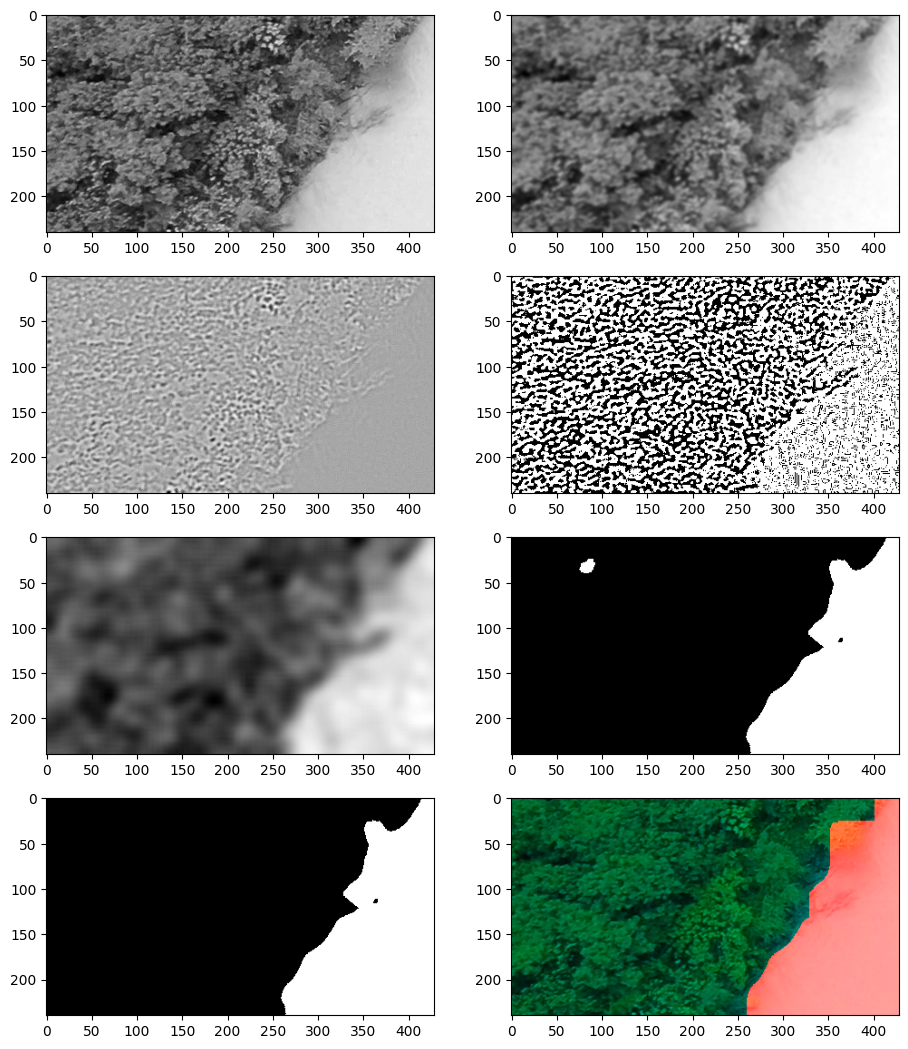

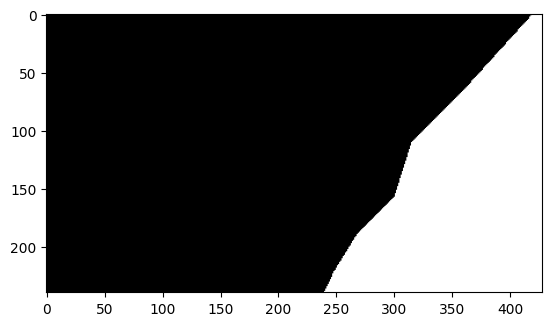

In [5]:
# Pre-processing of the input image

train_data = '/content/Training_dataset/'
img_old_path = train_data + 'img'
img_new_path = train_data + 'img_new'
os.makedirs(img_new_path, exist_ok=True)

def preprocess(old_path, new_path, sample):
    img_old = sorted([os.path.join(old_path, f) for f in os.listdir(old_path)])
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))

    for img_path in img_old:
        img_color = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Extract smooth texture area
        img_gaus1 = cv2.GaussianBlur(img_gray, (7, 7), 0)
        img_lap = cv2.Laplacian(img_gaus1, ddepth=-1, ksize=3, delta=128)
        _, img_binary1 = cv2.threshold(img_lap, 130, 255, cv2.THRESH_BINARY_INV)
        img_gaus2 = cv2.GaussianBlur(img_binary1, (51, 51), 0)
        _, img_binary2 = cv2.threshold(img_gaus2, np.average(img_gaus2)+10, 255, cv2.THRESH_BINARY)

        # Take the largest component
        num, labels = cv2.connectedComponents(img_binary2, connectivity=8)
        areas = [np.sum(labels == i) for i in range(num)]
        max_label = np.argmax(areas[1:]) + 1
        main_label = np.ma.masked_equal(labels, max_label)
        img_binary3 = np.array(main_label.mask * 255, dtype=np.uint8)

        # Closing
        img_binary4 = cv2.dilate(img_binary3, element)
        img_binary4 = cv2.erode(img_binary4, element, borderType=cv2.BORDER_REFLECT_101)
        img_color[:, :, 2] = img_binary4

        name = os.path.basename(img_path).replace('.jpg', '.png')
        cv2.imwrite(os.path.join(new_path, name), img_color)

        if img_path == sample:
            fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(11, 13))
            ax1.imshow(img_gray, cmap='gray')
            ax2.imshow(img_gaus1, cmap='gray')
            ax3.imshow(img_lap, cmap='gray')
            ax4.imshow(img_binary1, cmap='gray')
            ax5.imshow(img_gaus2, cmap='gray')
            ax6.imshow(img_binary2, cmap='gray')
            ax7.imshow(img_binary3, cmap='gray')
            ax8.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
            plt.show()

sample = '/content/Training_dataset/img/TRA_RI_2000001.jpg'
preprocess(img_old_path, img_new_path, sample)

gt = cv2.imread('/content/Training_dataset/label_img_new/TRA_RI_2000001.png', cv2.IMREAD_UNCHANGED)
plt.imshow(gt, cmap='gray')
plt.show()

In [6]:
# Check the number of images
!ls -l '/content/Training_dataset/label_img_new/' | wc -l
!ls -l '/content/Training_dataset/img_new/'  | wc -l

4321
4321


# **Data setting**
### 80% Training, 20% validation

In [6]:
!rm -r /content/tr/ /content/val/

# Create folders
category = '_RO'  # ['_RI', '_RO']
train_data = '/content/Training_dataset/'
tr_root = "/content/tr/"
val_root = "/content/val/"
os.makedirs(tr_root, exist_ok=True)
os.makedirs(val_root, exist_ok=True)
path_name = ['Imgs', 'GT_new', 'GT']
for name in path_name:
    os.makedirs(tr_root + name, exist_ok=True)
    os.makedirs(val_root + name, exist_ok=True)

img = sorted([os.path.join(train_data, 'img_new', f) \
              for f in os.listdir(train_data + 'img_new') if f.endswith('.png') and category in f])
GT = sorted([os.path.join(train_data, 'label_img', f) \
             for f in os.listdir(train_data + 'label_img') if f.endswith('.png') and category in f])
GT_new = sorted([os.path.join(train_data, 'label_img_new', f) \
             for f in os.listdir(train_data + 'label_img_new') if f.endswith('.png') and category in f])
print(f'Total image number: {len(img)}')

# Split training data
for i in range(len(img)):
    if i % 5 == 0:
        shutil.copy(img[i], val_root + 'Imgs/')
        shutil.copy(GT[i], val_root + 'GT/')
        shutil.copy(GT_new[i], val_root + 'GT_new/')
    else:
        shutil.copy(img[i], tr_root + 'Imgs/')
        shutil.copy(GT[i], tr_root + 'GT/')
        shutil.copy(GT_new[i], tr_root + 'GT_new/')

print('Training set image number:', len(os.listdir(tr_root + 'Imgs')))
print('Training set ground truth number:', len(os.listdir(tr_root + 'GT')))
print('Training set ground truth(new) number:', len(os.listdir(tr_root + 'GT_new')))
print('Validation set image number:', len(os.listdir(val_root + 'Imgs')))
print('Validation set ground truth number:', len(os.listdir(val_root + 'GT')))
print('Validation set ground truth(new) number:', len(os.listdir(val_root + 'GT_new')))


rm: cannot remove '/content/tr/': No such file or directory
rm: cannot remove '/content/val/': No such file or directory
Total image number: 2160
Training set image number: 1728
Training set ground truth number: 1728
Training set ground truth(new) number: 1728
Validation set image number: 432
Validation set ground truth number: 432
Validation set ground truth(new) number: 432


## **Dataset, DataLoader, and Transforms**

In [7]:
class GeneralDataset(Dataset): # 用於 training set 和 validation set 的 Dataset
    def __init__(self, image_root, gt_root, img_size, mode='train'):
      assert mode in ['train', 'val'] # mode 必須是' train' 或 'val'
      self.img_size = img_size
      self.mode = mode
      self.images = sorted([os.path.join(image_root, f) for f in os.listdir(image_root) if f.endswith('.png')])
      self.gts = sorted([os.path.join(gt_root, f) for f in os.listdir(gt_root) if f.endswith('.png')])
      self.filter_files()

      self.da_transform = transforms.Compose([
            RandomApply([RandomHorizontalFlip()], p=0.5)
      ])

      # image 預處理操作: 調整大小、轉換為 Tensor、標準化
      self.img_transform = transforms.Compose([
          transforms.Resize((self.img_size, self.img_size)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

      # ground truth 預處理操作: 調整大小並轉換為 Tensor
      self.gt_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()])

    def __getitem__(self, index):
      image = Image.open(self.images[index]).convert('RGB')# 打開圖像文件，轉換為RGB
      gt = Image.open(self.gts[index]).convert('L')# 打開圖像文件，轉換為灰階影像

      # 若為訓練模式，進行資料擴增
      if self.mode == "train":
        seed = torch.random.initial_seed()
        torch.manual_seed(seed)
        image = self.da_transform(image)
        torch.manual_seed(seed)
        gt = self.da_transform(gt)
      image = self.img_transform(image)
      gt = self.gt_transform(gt)
      return image, gt

    def filter_files(self):
      #確保 image 與 ground truth 數量必須匹配"
      assert len(self.images) == len(self.gts)
      images, gts = [], []
      for img_path, gt_path in zip(self.images, self.gts):
          img = Image.open(img_path)
          gt = Image.open(gt_path)
          if img.size == gt.size:
              images.append(img_path)
              gts.append(gt_path)
      self.images, self.gts = images, gts

    def __len__(self):
        return len(self.images)

In [8]:
class TestDataset(Dataset):# 用於 testing set 的 Dataset
    def __init__(self, image_root, img_size, category):
      self.images = sorted([os.path.join(image_root, f)
                           for f in os.listdir(image_root) if f.endswith('.png') and category in f])
      self.img_size = img_size
      self.img_transform = transforms.Compose([
        transforms.Resize((self.img_size, self.img_size)),
        transforms.ToTensor()])

    def __getitem__(self, index):
      image = Image.open(self.images[index]).convert('RGB')   # 打開圖像文件，轉換為 RGB
      image = self.img_transform(image)
      name = os.path.basename(self.images[index])
      return image, name

    def __len__(self):
      return len(self.images)

# **Define loss function**

In [9]:
# Define binary cross entropy loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pos_weight = torch.ones([1, 128, 128]) * 0.5
pos_weight = pos_weight.to(device)
bce_loss_module = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# **Training**

In [25]:
#設定權重儲存的路徑
def train(model, tr_loader, val_loader, save_path, label_id, epoch_num=30, lr=1e-4):
    os.makedirs(save_path, exist_ok=True)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    lr_lambda = lambda epoch: 0.95 ** epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    best_val_loss = float('inf')
    for epoch in range(epoch_num):
        ## -------------Training stage--------------
        model.train()
        loss_all = 0
        epoch_step = 0
        for images, gts in tr_loader:
            optimizer.zero_grad()
            images = images.to(device)
            gts = gts.to(device)

            # Mask label id "60": river, "6": road
            outputs = model(images).logits[:, label_id, :, :].unsqueeze(1)
            loss_bce = bce_loss_module(outputs, gts)

            loss = loss_bce
            loss.backward()
            optimizer.step()

            epoch_step += 1
            loss_all += loss.item()

        avg_train_loss = loss_all / epoch_step
        print(f'Train loss sample = {loss_bce.item()}')

        ## -------------Validation stage--------------
        model.eval()
        with torch.no_grad():
            val_loss_all = 0
            val_step = 0

            for images, gts in val_loader:
                images = images.to(device)
                gts = gts.to(device)

                outputs = model(images).logits[:, label_id, :, :].unsqueeze(1)
                loss_bce = bce_loss_module(outputs, gts)

                val_loss = loss_bce
                val_loss_all += val_loss.item()
                val_step += 1

            avg_val_loss = val_loss_all / val_step

        scheduler.step()

        # 儲存最好的權重
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(save_path, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print('New best model saved at epoch', epoch)

        # 每 10 個 epoch 儲存一次權重
        if epoch % 10 == 0:
            model_save_path = os.path.join(save_path, f'Net_epoch_{epoch}.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved at epoch {epoch}')

        print(f"Epoch [{epoch}/{epoch_num}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    print(f"Training complete. Best model saved to {best_model_path}")

## **Model: SegFormer**
Reference: https://huggingface.co/docs/transformers/model_doc/segformer

In [26]:
from transformers import SegformerForSemanticSegmentation

# 指定 training set 和 validation set 的路徑
tr_root = "/content/tr"
val_root = "/content/val"
img_size = 512

# 使用 DataLoader 來包裝 training set 和 validation set
# - mode: 設置數據集的模式，設定為 "train "則會做資料擴增
tr_datastet = GeneralDataset(image_root=os.path.join(tr_root, "Imgs"),
                gt_root=os.path.join(tr_root, "GT_new"),
                img_size=img_size, mode="train")
val_datastet = GeneralDataset(image_root=os.path.join(val_root, "Imgs"),
                gt_root=os.path.join(val_root, "GT_new"),
                img_size=img_size, mode="val")

tr_loader = DataLoader(dataset = tr_datastet, batch_size=24, shuffle=True,
                  num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset = val_datastet, batch_size=24, shuffle=True,
                  num_workers=2, pin_memory=True)

model = SegformerForSemanticSegmentation.from_pretrained(
             "nvidia/segformer-b1-finetuned-ade-512-512")
model.to(device)
save_path = '/content/models' + category + '/'

# Run model.config to show "id to label" list.
# model.config
label_id = 60 if category == '_RI' else 6  # SegFormer label id: 60: river, 6: road


# Model training: input fusion image to predict block mask
train(model, tr_loader, val_loader, save_path, label_id, epoch_num=30, lr=1e-4)


Train loss sample = 0.08842965960502625
New best model saved at epoch 0
Model saved at epoch 0
Epoch [0/30], Train Loss: 0.3824, Val Loss: 0.1154
Train loss sample = 0.07611951231956482
New best model saved at epoch 1
Epoch [1/30], Train Loss: 0.1042, Val Loss: 0.0921
Train loss sample = 0.09039242565631866
New best model saved at epoch 2
Epoch [2/30], Train Loss: 0.0827, Val Loss: 0.0702
Train loss sample = 0.06187529116868973
New best model saved at epoch 3
Epoch [3/30], Train Loss: 0.0708, Val Loss: 0.0684
Train loss sample = 0.05020470172166824
New best model saved at epoch 4
Epoch [4/30], Train Loss: 0.0630, Val Loss: 0.0574
Train loss sample = 0.052853748202323914
New best model saved at epoch 5
Epoch [5/30], Train Loss: 0.0568, Val Loss: 0.0537
Train loss sample = 0.034139133989810944
New best model saved at epoch 6
Epoch [6/30], Train Loss: 0.0499, Val Loss: 0.0495
Train loss sample = 0.03866221755743027
New best model saved at epoch 7
Epoch [7/30], Train Loss: 0.0454, Val Loss

# **Inference**

In [10]:
# Unzip test dataset
!unzip -q "/content/drive/MyDrive/AICUP_2024/35_Competition 2_public testing dataset.zip" -d /content/ts/
!unzip -q "/content/drive/MyDrive/AICUP_2024/35_Competition 2_Private Test Dataset.zip" -d /content/ts/
!cp -r "/content/ts/35_Competition 2_Private Test Dataset/img/." /content/ts/img/

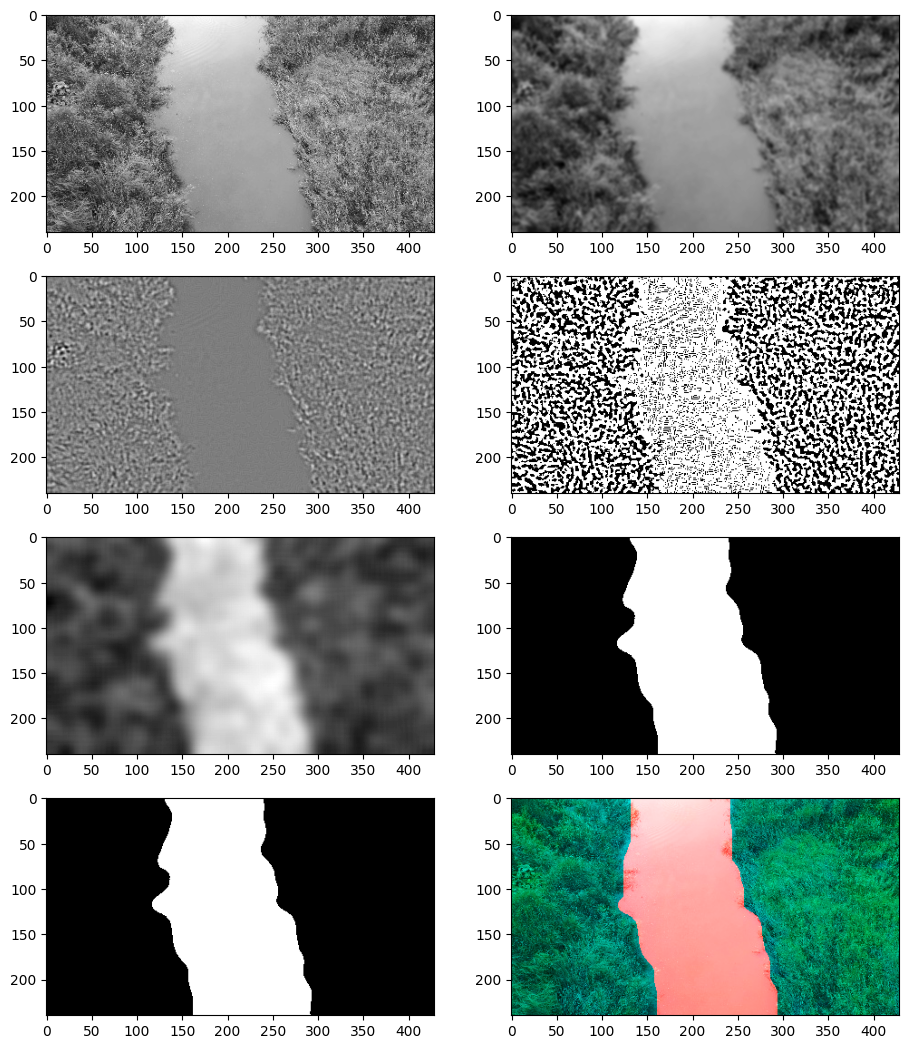

In [12]:
# Image pre-processing of test dataset
ts_root = '/content/ts/'
ts_old_path = ts_root + 'img'
ts_new_path = ts_root + 'img_new'
os.makedirs(ts_new_path, exist_ok=True)
sample = '/content/ts/img/PUB_RI_2000000.jpg'

preprocess(ts_old_path, ts_new_path, sample)

In [25]:
# Make the block mask prediction

Test = False  # True: Predict test dataset; False: Predict validation dataset
if Test:
    ts_root = "/content/ts"
    ts_dataset = TestDataset(image_root=os.path.join(ts_root, "img_new"), img_size=img_size, category=category)
    save_path = "/content/ts/result_new" + category
else:
    ts_root = "/content/val"
    ts_dataset = TestDataset(image_root=os.path.join(ts_root, "Imgs"), img_size=img_size, category=category)
    save_path = "/content/val/result_new"

os.makedirs(save_path, exist_ok=True)
ts_loader = DataLoader(dataset=ts_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

model = SegformerForSemanticSegmentation.from_pretrained(
         "nvidia/segformer-b1-finetuned-ade-512-512")
model.load_state_dict(torch.load(f"/content/models{category}/best_model.pth"))
model.cuda()
model.eval()
label_id = 60 if category == '_RI' else 6  # 60: river, 6: road

with torch.no_grad():
    for images, names in ts_loader:
        images = images.cuda()

        results = model(images).logits[:, label_id, :, :].unsqueeze(1)
        results = F.interpolate(results, size=(240, 428), mode='bilinear', align_corners=False)
        results = results.data.cpu().numpy()
        for idx, name in enumerate(names):
            res = results[idx].squeeze()
            success = cv2.imwrite(os.path.join(save_path, name), res * 255)
            if success: pass
            else:
                print(f"Failed to save file: {name}")

## **Post-processing**

In [34]:
# If Test == True, skip this cell.

# Find best post-processing parameter in validation set
pred_new_root = '/content/val/result_new'
mask_root = '/content/val/GT'
mask_list = sorted(os.listdir(mask_root))

element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
FMv2_temp = py_sod_metrics.FmeasureV2(
    metric_handlers={
        "fm": py_sod_metrics.FmeasureHandler(with_dynamic=True,
                                             with_adaptive=False, beta=0.3),
    })
fm_best = 0
early_stop = 0

for g_size in range(1, 100, 6):
    print(f'Evaluating g_size {g_size}')
    for thr in range(1, 6):
        for i, mask_name in enumerate(mask_list):
            mask_path = os.path.join(mask_root, mask_name)
            pred_path = os.path.join(pred_new_root, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            pred_raw = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

            pred_gaus = cv2.GaussianBlur(pred_raw, (g_size, g_size), 0)
            _, pred = cv2.threshold(pred_gaus, thr, 255, cv2.THRESH_BINARY)
            pred_erod = cv2.erode(pred, element, borderType=cv2.BORDER_CONSTANT, borderValue=0)
            pred = pred - pred_erod

            # Take the largest component
            num, labels = cv2.connectedComponents(pred, connectivity=8)
            areas = [np.sum(labels == i) for i in range(num)]
            max_label = np.argmax(areas[1:]) + 1 if len(areas) > 1 else 0
            main_label = np.ma.masked_equal(labels, max_label)
            pred_mask = np.array(main_label.mask)
            pred = pred_raw * pred_mask

            FMv2_temp.step(pred=pred, gt=mask)

        fmv2 = FMv2_temp.get_results()["fm"]["dynamic"].mean()
        if fmv2 > fm_best:
            fm_best = fmv2
            best_g_size = g_size
            best_thr = thr
            early_stop = 0

        FMv2_temp._metric_handlers['fm'].dynamic_results = []

    print(f"Current fmv2: {fmv2:.4f}, Best g_size: {best_g_size}, Best thr: {best_thr}, Best fm: {fm_best:.4f}")

    early_stop += 1
    if early_stop >= 5:
        print("Early stop.")
        break

Evaluating g_size 1
Current fmv2: 0.7160, Best g_size: 1, Best thr: 1, Best fm: 0.7180
Evaluating g_size 7
Current fmv2: 0.7649, Best g_size: 7, Best thr: 1, Best fm: 0.7705
Evaluating g_size 13
Current fmv2: 0.7711, Best g_size: 13, Best thr: 1, Best fm: 0.7712
Evaluating g_size 19
Current fmv2: 0.7712, Best g_size: 19, Best thr: 1, Best fm: 0.7712
Evaluating g_size 25
Current fmv2: 0.7712, Best g_size: 25, Best thr: 2, Best fm: 0.7721
Evaluating g_size 31
Current fmv2: 0.7718, Best g_size: 25, Best thr: 2, Best fm: 0.7721
Evaluating g_size 37
Current fmv2: 0.7718, Best g_size: 25, Best thr: 2, Best fm: 0.7721
Evaluating g_size 43
Current fmv2: 0.7718, Best g_size: 25, Best thr: 2, Best fm: 0.7721
Evaluating g_size 49
Current fmv2: 0.7718, Best g_size: 25, Best thr: 2, Best fm: 0.7721
Early stop.


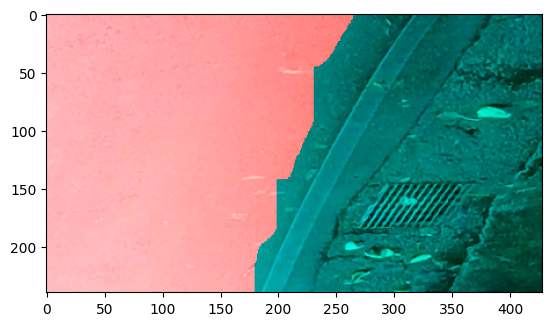

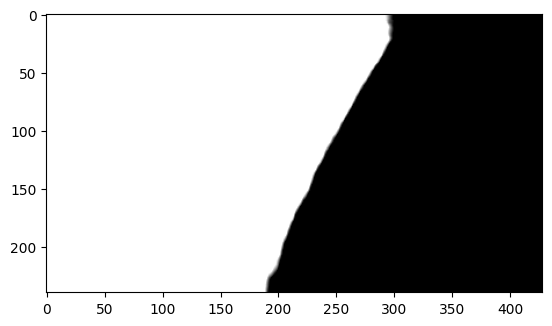

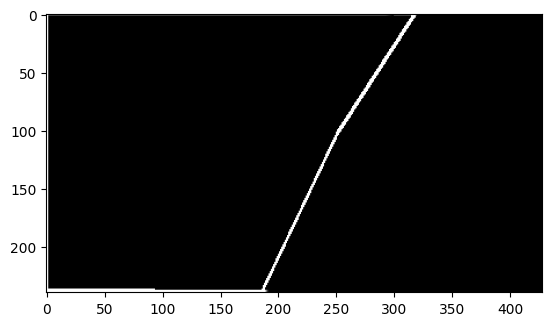

In [28]:
# Transform the white block mask to the edge form label.

application = False
if Test:
    testing_data = '/content/ts/'
    pred_new_path = testing_data + 'result_new' + category  # Block form prediction
else:
    testing_data = '/content/val/'
    pred_new_path = testing_data + 'result_new'  # Block form prediction

pred_old_path = testing_data + 'result'      # Edge form prediction
os.makedirs(pred_new_path, exist_ok=True)
os.makedirs(pred_old_path, exist_ok=True)

pred_new = sorted([os.path.join(pred_new_path, f) for f in os.listdir(pred_new_path)])
element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# best_g_size, best_thr = 31, 1  # Determined in previous section

for pred_file in pred_new:
    pred_raw = cv2.imread(pred_file, cv2.IMREAD_GRAYSCALE)

    pred_gaus = cv2.GaussianBlur(pred_raw, (best_g_size, best_g_size), 0)
    _, pred = cv2.threshold(pred_gaus, best_thr, 255, cv2.THRESH_BINARY)
    pred_erod = cv2.erode(pred, element, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    pred = pred - pred_erod

    # Take the largest component
    num, labels = cv2.connectedComponents(pred, connectivity=8)
    areas = [np.sum(labels == i) for i in range(num)]
    max_label = np.argmax(areas[1:]) + 1 if len(areas) > 1 else 0
    main_label = np.ma.masked_equal(labels, max_label)

    if application == True:
        pred_show = np.array(main_label.mask * 255)  # Show bright line, with lower precision

    pred_mask = np.array(main_label.mask)  # Show dark line, with higher precision and FM score
    pred = pred_raw * pred_mask

    if np.average(pred) == 0.0:   # Black prediction
        pred = np.zeros((240, 428))

    path_old = os.path.join(pred_old_path, os.path.split(pred_file)[-1])
    if application == True:
        success = cv2.imwrite(path_old, pred_show)
    else:
        success = cv2.imwrite(path_old, pred)

    if not success:
        print(f"Failed to save file: {name}")

if category == '_RI':
    image = cv2.imread('/content/val/Imgs/TRA_RI_2000000.png', cv2.IMREAD_UNCHANGED)
    pred_block = cv2.imread('/content/val/result_new/TRA_RI_2000000.png', cv2.IMREAD_UNCHANGED)
    pred_edge = cv2.imread('/content/val/result/TRA_RI_2000000.png', cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread('/content/val/GT/TRA_RI_2000000.png', cv2.IMREAD_GRAYSCALE)

if category == '_RO':
    image = cv2.imread('/content/val/Imgs/TRA_RO_2002170.png', cv2.IMREAD_UNCHANGED)
    pred_block = cv2.imread('/content/val/result_new/TRA_RO_2002170.png', cv2.IMREAD_UNCHANGED)
    pred_edge = cv2.imread('/content/val/result/TRA_RO_2002170.png', cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread('/content/val/GT/TRA_RO_2002170.png', cv2.IMREAD_GRAYSCALE)


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(pred_block, cmap='gray')
plt.show()

if application == True:
    plt.imshow(pred_edge, cmap='gray')
else:
    plt.imshow((gt + pred_edge) / 2, cmap='gray')
plt.show()

# **Evaluation**

In [36]:
#設定模型預測結果的路徑
pred_root = '/content/val/result'
pred_new_root = '/content/val/result_new'
#設定 ground truth 路徑
mask_root = '/content/val/GT'
mask_new_root = '/content/val/GT_new'

# 計算 Mean F-measure
mask_name_list = sorted(os.listdir(mask_root))
mask_new_name_list = sorted(os.listdir(mask_new_root))
FMv2 = py_sod_metrics.FmeasureV2(
    metric_handlers={
        "fm": py_sod_metrics.FmeasureHandler(with_dynamic=True,
                                             with_adaptive=False, beta=0.3),
    })
FMv2_new = py_sod_metrics.FmeasureV2(
    metric_handlers={
        "fm": py_sod_metrics.FmeasureHandler(with_dynamic=True,
                                             with_adaptive=False, beta=0.3),
    })

# Block form
for i, mask_name in enumerate(mask_new_name_list):
    #print(f"[{i}] Processing {mask_name}...")
    mask_path = os.path.join(mask_new_root, mask_name)
    pred_path = os.path.join(pred_new_root, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    FMv2_new.step(pred=pred, gt=mask)

fmv2_new = FMv2_new.get_results()
results_new = {
    "meanfm(block)": fmv2_new["fm"]["dynamic"].mean()
}

# Edge form
for i, mask_name in enumerate(mask_name_list):
    #print(f"[{i}] Processing {mask_name}...")
    mask_path = os.path.join(mask_root, mask_name)
    pred_path = os.path.join(pred_root, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    FMv2.step(pred=pred, gt=mask)

fmv2 = FMv2.get_results()
results = {
    "meanfm(edge)": fmv2["fm"]["dynamic"].mean()
}

print('Validation set FM score:')
print(results_new)
print(results)

Validation set FM score:
{'meanfm(block)': 0.9740151435276879}
{'meanfm(edge)': 0.7720513830073905}


# **Submission**

After making RI and RO prediction of the test dataset, you can make a submission.

In [ ]:
# Make sure the file number is correct
!ls -l '/content/ts/img/' | wc -l
!ls -l '/content/ts/result/' | wc -l

#壓縮檔案成zip檔
directory_to_compress = '/content/ts/result'
shutil.make_archive('submission_file_15', 'zip', directory_to_compress)

1441
1441


'/content/submission_file_15.zip'